### Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

### Load data

In [4]:
train_features = pd.read_csv('data/train_features.csv')
train_targets = pd.read_csv('data/train_targets.csv')

test_features = pd.read_csv('data/test_features.csv')

### EDA

In [5]:
FEATURE_COLUMNS = ['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate']
TARGET_COLUMNS = ['B_C2H6', 'B_C3H8', 'B_iC4H10', 'B_nC4H10']

In [6]:
train_features

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,2020-01-01 00:00:00,70.855017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.982789
1,2020-01-01 00:30:00,70.826582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.965098
2,2020-01-01 01:00:00,70.809637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.867409
3,2020-01-01 01:30:00,69.994748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.839126
4,2020-01-01 02:00:00,70.072762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.336921
...,...,...,...,...,...,...,...,...,...,...,...
5803,2020-04-30 21:30:00,72.009730,0.284151,4.936343,35.758852,16.473834,24.318968,6.069360,5.527463,6.577563,74.183355
5804,2020-04-30 22:00:00,71.854180,0.282501,4.960453,35.877193,16.448487,24.074193,5.981357,5.407256,6.915378,74.213066
5805,2020-04-30 22:30:00,71.783273,0.277686,5.013878,36.271557,16.500147,24.010123,5.829363,5.160329,6.884173,74.144367
5806,2020-04-30 23:00:00,71.717743,0.271106,5.080144,36.616673,16.559533,24.008848,5.750492,5.017941,6.642076,74.320575


In [7]:
train_targets

,timestamp,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
0,2020-01-01 00:00:00,4.561979,39.015486,17.250740,24.301793
1,2020-01-01 00:30:00,4.550741,39.048915,17.229506,24.257461
2,2020-01-01 01:00:00,4.506793,38.766378,17.171621,24.236298
3,2020-01-01 01:30:00,4.584963,39.069360,17.218521,24.149843
4,2020-01-01 02:00:00,4.607483,38.817579,17.108668,24.049510
...,...,...,...,...,...
5803,2020-04-30 21:30:00,4.816865,35.539156,16.269938,24.770377
5804,2020-04-30 22:00:00,4.993286,36.067750,16.317757,24.729847
5805,2020-04-30 22:30:00,5.101574,36.275040,16.295460,24.629889
5806,2020-04-30 23:00:00,5.210675,36.872917,16.336359,24.438236


In [8]:
test_features

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,2020-05-01 00:00:00,71.428342,0.267832,5.135159,36.816480,16.632260,24.062587,5.696004,4.939430,6.395286,74.273009
1,2020-05-01 00:30:00,70.925118,0.268464,5.149646,36.869023,16.651870,24.069800,5.676384,4.911872,6.346957,74.061833
2,2020-05-01 01:00:00,70.991719,0.270641,5.154615,37.074965,16.710967,24.106152,5.574873,4.808516,6.242636,73.856268
3,2020-05-01 01:30:00,70.972406,0.275241,5.230661,37.384180,16.683337,24.021993,5.514843,4.730887,6.101647,73.750744
4,2020-05-01 02:00:00,70.980078,0.275062,5.241437,37.448587,16.663863,24.003237,5.524898,4.728882,6.057119,73.698447
...,...,...,...,...,...,...,...,...,...,...,...
3979,2020-07-22 21:30:00,72.600912,0.120985,4.328092,40.875930,17.741460,24.098520,4.469224,3.619095,4.686205,75.486026
3980,2020-07-22 22:00:00,72.107049,0.110734,4.013567,38.871418,17.449352,24.049532,4.770699,3.988215,6.689777,75.370451
3981,2020-07-22 22:30:00,71.805799,0.111535,4.041506,39.794323,17.635380,24.169473,4.613603,3.790651,5.785216,74.985878
3982,2020-07-22 23:00:00,72.112046,0.119362,4.131432,40.461503,17.758833,24.211013,4.504242,3.657459,5.094626,74.766867


In [39]:
def plot_series(df, layout=None, figsize=(15,15)):
    df.plot(kind='line', subplots=True, grid=True, layout=layout, sharex=True, figsize=figsize)

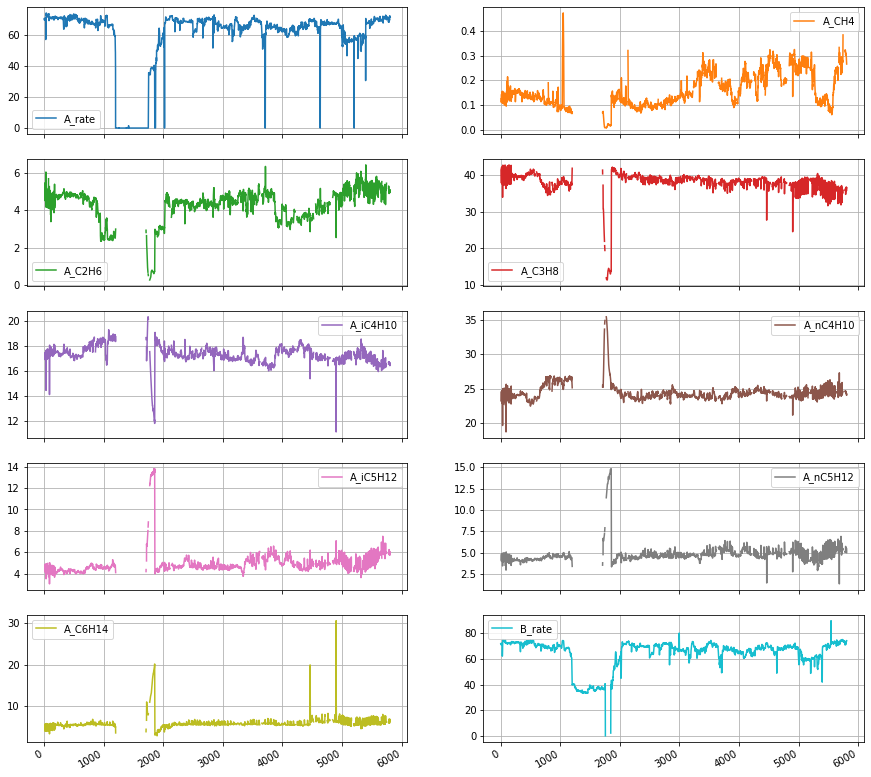

In [40]:
plot_series(train_features[FEATURE_COLUMNS], layout=(5,2))

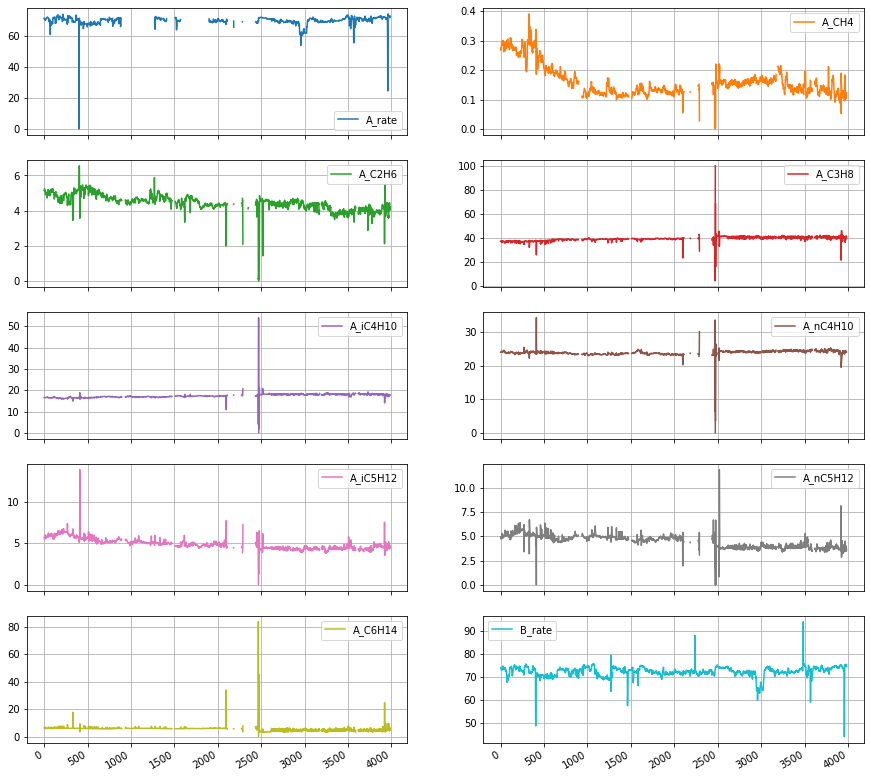

In [41]:
plot_series(test_features[FEATURE_COLUMNS], layout=(5,2))

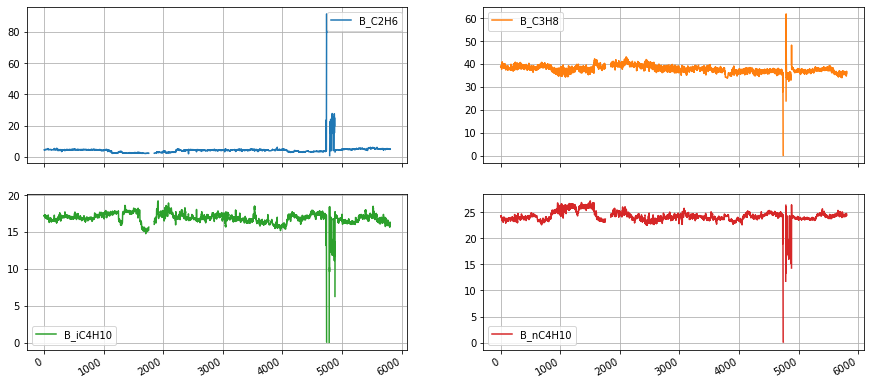

In [43]:
plot_series(train_targets[TARGET_COLUMNS], layout=(2,2), figsize=(15, 7))